## Data Generator

In [1]:
import sys
print(sys.version)

2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
# Add relative path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
from utils.parse_txt_to_inputs import parse_txt_to_inputs    # Data handler for LISA dataset

x_train, y_train = parse_txt_to_inputs('../training.txt')
labels           = np.unique(y_train[:,1])
num_classes      = len(labels)  # Count number of classes in the dataset

print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))

Number of ground truth boxes: 11527 boxes
Train: 11527 samples
Number of classes: 56


    frequency                    label  scaling_factor
0         296                addedLane               8
1          20   bicyclesMayUseFullLane             123
2          87                curveLeft              28
3         109               curveRight              22
4          35                      dip              70
5          62               doNotEnter              39
6           9                doNotPass             274
7          13             intersection             190
8          24  intersectionLaneControl             102
9         458                keepRight               5
10        257                 laneEnds               9
11          6      leftAndUTurnControl             411
12        284                    merge               8
13         73           noLeftAndUTurn              33
14         47               noLeftTurn              52
15          8                noParking             308
16         42              noRightTurn              58
17        

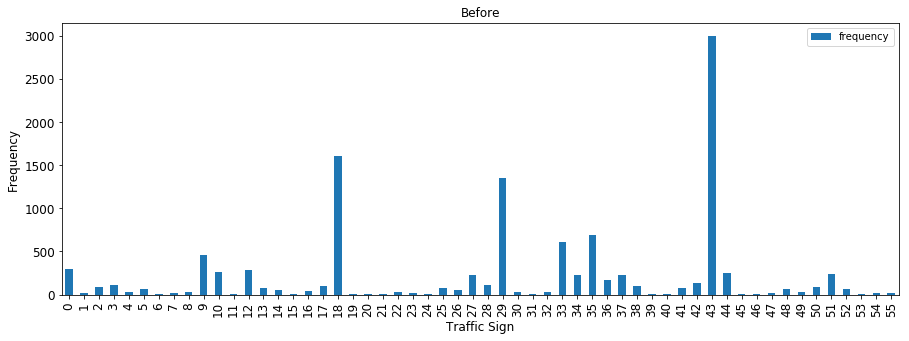

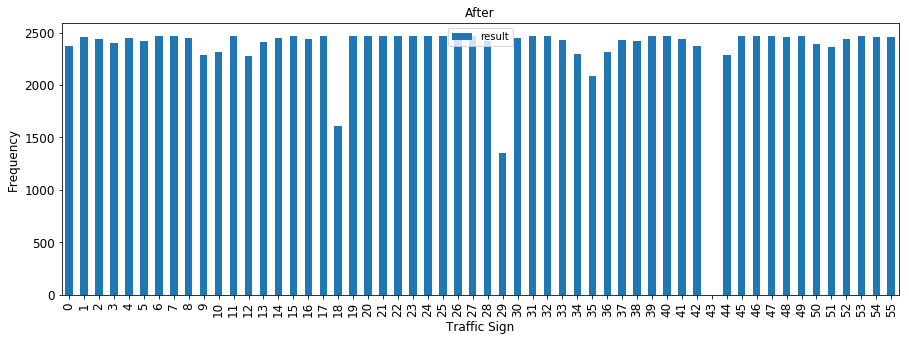

In [16]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from utils.data_generator import calc_augment_level

df = calc_augment_level(y_train, scaling_factor=12)  # (less data / class means more augmentation)
print(df)
ax = df[['label','frequency']].plot(kind='bar', title='Before', figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("Traffic Sign", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

df['result'] = df.frequency*df.scaling_factor
plt.figure()
ax = df[['label','result']].plot(kind='bar', title='After', figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("Traffic Sign", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

    frequency                    label  scaling_factor  result
0         296                addedLane              10    2960
1          20   bicyclesMayUseFullLane             154    3080
2          87                curveLeft              35    3045
3         109               curveRight              28    3052
4          35                      dip              88    3080
5          62               doNotEnter              49    3038
6           9                doNotPass             343    3087
7          13             intersection             237    3081
8          24  intersectionLaneControl             128    3072
9         458                keepRight               6    2748
10        257                 laneEnds              12    3084
11          6      leftAndUTurnControl             514    3084
12        284                    merge              10    2840
13         73           noLeftAndUTurn              42    3066
14         47               noLeftTurn              65 

In [ ]:
from cfg import *

    # Get list of classes
fl = open(CATEGORIES, 'r')
CLASSES = np.array(fl.read().splitlines())
fl.close()


In [ ]:
import pandas as pd

categories = np.unique(y_train[:, 1])
label_map  = pd.factorize(categories)[0]


In [ ]:
from utils.data_generator import flow_from_list
from cfg import *

data_gen   = flow_from_list(x_train, y_train, batch_size=4, scaling_factor=5, augment_data=True)

In [ ]:
images, labels  = data_gen.next()

print("Images shape {}".format(images[0].shape))
GRID_W = np.shape(images)[2]/ SHRINK_FACTOR
GRID_H = np.shape(images)[1]/ SHRINK_FACTOR

labels = labels.reshape([-1, GRID_H, GRID_W, N_ANCHORS, N_CLASSES+5])
print("List of images : {}".format(np.shape(images)))
print("List of labels : {}\n".format(np.shape(labels)))

In [ ]:
from utils.image_handler import draw_boxes
from utils.box import Box
import matplotlib.pyplot as plt
%matplotlib inline
i = np.random.randint(0, 4)
height, width, _ = images[i].shape

tmp = labels[i][labels[i] > 0.]
if len(tmp[0:4]) == 0 :
    bbox = Box(0,0,0,0)
else:
    xc, yc, w ,h = tmp[tmp > 0][0:4]
    bbox = Box(xc, yc, w ,h)
    bbox.to_abs_size((width, height))
    opencv_box = bbox.to_opencv_format()
print(bbox)
plt.figure(figsize=(15, 15))
plt.imshow(draw_boxes(images[i], opencv_box, color=[0, 1, 0], thickness=2))

In [ ]:
import cv2
img = images[0]
height, width, c = img.shape

shrink_factor = 32
grid_w = list(range(width/shrink_factor))
grid_h = list(range(height/shrink_factor))
center = 0
# Plot grid map
for r in grid_w:
    img = cv2.line(img,(r*shrink_factor, 0), (r*shrink_factor, height), color=(0, 1, 0), thickness=2)
    
for h in grid_h:
    img = cv2.line(img,(0, h*shrink_factor), (width, h*shrink_factor), color=(0, 1, 0), thickness=2)
    
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [ ]:
# Test if it is in correct cell, this case, traffic sign is located in cell r=6, c=17
a = labels[0][labels[0] > 0.]

center = (height - 15*shrink_factor, width - 6*shrink_factor)
print(center)
p1 = (center[0] - 16, center[1] - 16)
p2 = (center[0] + 16, center[1] + 16)
result = cv2.rectangle(img, p1, p2, (0, 1, 0), thickness=cv2.FILLED)

plt.imshow(result)

In [ ]:
from utils.image_handler import draw_boxes
from utils.box import Box
import matplotlib.pyplot as plt
%matplotlib inline

label_map = np.unique(y_train[:, 1])
row, col = 2, 2
fg, a    = plt.subplots(row, col, figsize =(20, 15))
fg.tight_layout()
height, width, _ = images[0].shape
print("Image size:", images[0].shape)
i        = 0
for r in range(row):
    for c in range(col):
        tmp = labels[i][labels[i] > 0.]
        if len(tmp[0:4]) == 0 :
            bbox = Box(0,0,0,0)
        else:
            xc, yc, w ,h = tmp[tmp > 0][0:4]
            bbox = Box(xc, yc, w ,h)
            print(bbox)
        bbox.to_abs_size((width, height))
        opencv_box = bbox.to_opencv_format()
        print(opencv_box)
        a[r, c].axis('off')
        a[r, c].imshow(draw_boxes(images[i], opencv_box, color=(255, 255, 255), thickness=2))
        a[r, c].set_title(str(i))
        i +=1